##### Import libraries

In [57]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline

In [58]:
df = pd.read_csv('owid-energy-data.csv')
df.head()

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_consumption,biofuel_elec_per_capita,...,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_cons_change_twh,wind_consumption,wind_elec_per_capita,wind_electricity,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,1900,AFG,4832414.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,1901,AFG,4879685.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Afghanistan,1902,AFG,4935122.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Afghanistan,1903,AFG,4998861.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Afghanistan,1904,AFG,5063419.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21890 entries, 0 to 21889
Columns: 129 entries, country to wind_share_energy
dtypes: float64(126), int64(1), object(2)
memory usage: 21.5+ MB


## Data cleaning - Time period selecton based on NaN values
We find a reasonable amount of NaN values that we accept based on the NaN counts across all year.

Another consideration is the time period has to be recent, hence we start from 2022 and work backwards.

In [60]:
# for year 2021, this is the number of NaN values across the columns
df[df['year'] == 2021].isna().sum().sum()

14184

In [61]:
# initialise new dataframe to store NaN counts
nan_count = pd.DataFrame(columns=['year', 'nan_counts'])

In [62]:
# for each year in the dataset, tally the number of NaN values to determine which year to cut off onwards
# takes quite a while to append (around 44s)
for year in df['year']:
    count = df[df['year'] == year].isna().sum().sum()
    row = [year, count]
    row_df = pd.DataFrame([row], columns = nan_count.columns)
    nan_count = pd.concat([nan_count, row_df], ignore_index=True)

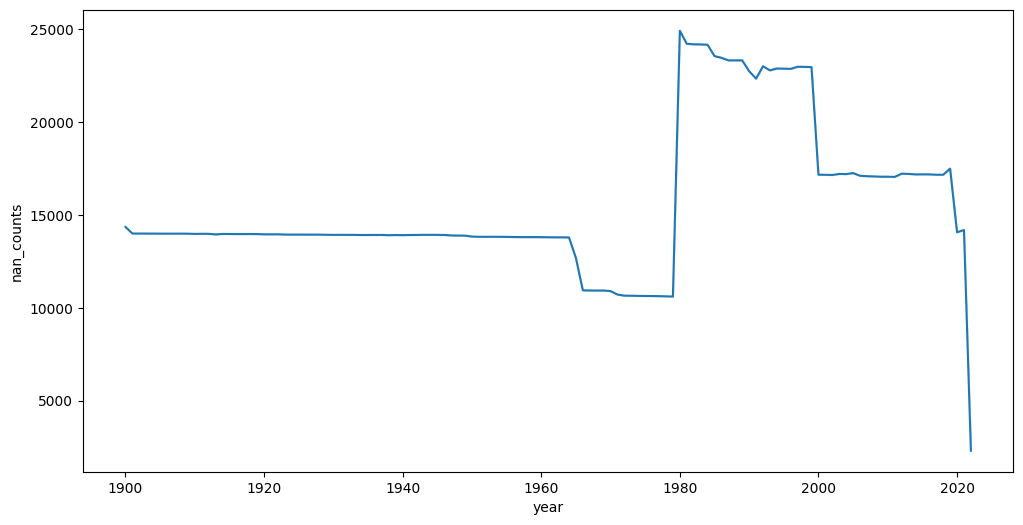

In [63]:
# from the graph, we backtrack to a reasonable time period where null values are at an acceptable range - around year 2000
figure = plt.figure(figsize=(12,6))
sb.lineplot(data=nan_count, x = 'year', y = 'nan_counts');

In [64]:
# A quick check on the number of rows in the data shows that 2022 has a lot of missing rows, despite low NaN value counts
df['year'].value_counts().sort_values()

2022     29
1903    119
1904    119
1905    119
1906    119
       ... 
2015    299
2013    299
2012    299
2016    299
2014    299
Name: year, Length: 123, dtype: int64

Hence we restrict the years to 2000 - 2021 for subsequent analysis

In [65]:
df = df[(df['year'] > 2000) & (df['year'] < 2022)]

## Data Cleaning: Column Filtering based on relevancy

Filter out columns that are too specific and are not 'per capita' or the like - we may get back to them later but this step narrows our focus down to more relevant data

We want to compare the relative changes in the various energy consumption/generation. 

We keep some absolute metrics that are more general like greenhouse gas emissions, fossil fuel consumption etc. as it still gives us a brief overview on what to focus on.

In [66]:
# hardcoded the index to remove -> refer to excel where it represents the start of the red-highlighted rows
rm_cols = ['biofuel_consumption', 'biofuel_electricity', 'coal_cons_change_twh', 'coal_consumption', 'coal_electricity', 
           'coal_prod_change_twh', 'coal_production', 'electricity_generation', 'fossil_cons_change_twh', 'gas_cons_change_twh', 
           'gas_consumption', 'gas_electricity', 'gas_prod_change_twh', 'gas_production', 'hydro_cons_change_twh', 'hydro_consumption', 
           'hydro_electricity', 'low_carbon_cons_change_twh', 'net_elec_imports', 'nuclear_cons_change_twh', 'nuclear_consumption', 
           'nuclear_electricity', 'oil_cons_change_twh', 'oil_consumption', 'oil_electricity', 'oil_prod_change_twh', 'oil_production', 
           'other_renewable_consumption', 'other_renewable_electricity', 'other_renewable_exc_biofuel_electricity', 'other_renewables_cons_change_twh', 
           'per_capita_electricity', 'primary_energy_consumption', 'renewables_cons_change_twh', 'solar_cons_change_twh', 'solar_consumption', 'solar_electricity', 
           'wind_cons_change_twh', 'wind_consumption', 'wind_electricity']

In [67]:
# drop less relevant columns
df1 = df.drop(columns = rm_cols)
df1

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_elec_per_capita,biofuel_share_elec,...,solar_cons_change_pct,solar_elec_per_capita,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_elec_per_capita,wind_energy_per_capita,wind_share_elec,wind_share_energy
101,Afghanistan,2001,AFG,19688634.0,1.102127e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
102,Afghanistan,2002,AFG,21000258.0,1.880487e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
103,Afghanistan,2003,AFG,22645136.0,2.107434e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
104,Afghanistan,2004,AFG,23553554.0,2.233257e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
105,Afghanistan,2005,AFG,24411196.0,2.539769e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.0,NaN,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21885,Zimbabwe,2017,ZWE,14751101.0,2.194784e+10,NaN,NaN,NaN,21.693,4.354,...,NaN,0.678,NaN,0.136,NaN,NaN,0.0,NaN,0.0,NaN
21886,Zimbabwe,2018,ZWE,15052191.0,2.271535e+10,NaN,NaN,NaN,25.910,4.244,...,NaN,1.329,NaN,0.218,NaN,NaN,0.0,NaN,0.0,NaN
21887,Zimbabwe,2019,ZWE,15354606.0,NaN,NaN,NaN,NaN,24.748,4.612,...,NaN,1.954,NaN,0.364,NaN,NaN,0.0,NaN,0.0,NaN
21888,Zimbabwe,2020,ZWE,15669663.0,NaN,NaN,NaN,NaN,22.336,4.605,...,NaN,1.915,NaN,0.395,NaN,NaN,0.0,NaN,0.0,NaN


## Data Cleaning - Column filtering based on NaN values

Note that a lot of the NaN values are attributed to the nature of the data - not all countries have the ability to produce wind energy for example

Hence, for starters, we only narrow it down further as the EDA becomes more specific - for now, we take note of the columns with significant NaN values.

In [68]:
# percentage of null values to total number of values
pct_null = df1.isnull().sum() / len(df1)
pct_null.sort_values(ascending=False).head(10)

biofuel_cons_per_capita             0.910944
biofuel_cons_change_pct             0.894145
biofuel_share_energy                0.880117
biofuel_cons_change_twh             0.880117
nuclear_cons_change_pct             0.830533
solar_cons_change_pct               0.729082
nuclear_energy_per_capita           0.720763
wind_cons_change_pct                0.717664
other_renewables_cons_change_pct    0.709020
fossil_energy_per_capita            0.695808
dtype: float64

## Exploratory Data Analysis - Continents + Countries
First, we remove rows in 'country' column that are not considered countries or continents - such as G7, G20, Yugoslavia, Czechoslovakia

In [69]:
# countries.csv is extracted from online where it contains ISO 3166-1 alpha-3 codes of 193 recognised countries
iso_codes = pd.read_csv('countries.csv')
alpha3 = iso_codes['alpha3'].apply(str.upper).unique()
len(alpha3)

193

In [70]:
# there are 6 missing countries in the dataframe
iso_countries = df1[df1['iso_code'].isin(alpha3)]['iso_code'].unique()
len(iso_countries)

187

In [71]:
# make alpha3 into a dataframe (from a numpy array) to check for missing countries
df_alpha3 = pd.DataFrame(alpha3)

mis_countries = df_alpha3[~df_alpha3.isin(iso_countries)].dropna()
mis_countries

,0
3,AND
99,LIE
108,MHL
114,MCO
132,PLW
148,SMR


The officially recognised countries (based on ISO 3166-1 alpha3 codes) not included are: **Andorra, Liechtenstein, Marshall Islands, Monacoo, Palau and San Marino**

We don't need to include their data as they are relatively small countries

We include continents for a broad analysis before diving into individual countries (without (Ember), (Shift) and (BP) as their data columns are merely subsets of the continents themselves)

In [72]:
# initialise new dataframe with valid countries + continents
continents = ['Africa', 'Asia', 'Europe', 'North America', 'South America', 'Oceania']
df2 = pd.concat([df1[df1['iso_code'].isin(iso_countries)], df1[df1['country'].isin(continents)]], ignore_index=True)
df2

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_elec_per_capita,biofuel_share_elec,...,solar_cons_change_pct,solar_elec_per_capita,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_elec_per_capita,wind_energy_per_capita,wind_share_elec,wind_share_energy
0,Afghanistan,2001,AFG,19688634.0,1.102127e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
1,Afghanistan,2002,AFG,21000258.0,1.880487e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
2,Afghanistan,2003,AFG,22645136.0,2.107434e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
3,Afghanistan,2004,AFG,23553554.0,2.233257e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
4,Afghanistan,2005,AFG,24411196.0,2.539769e+10,NaN,NaN,NaN,0.000,0.000,...,NaN,0.000,NaN,0.000,NaN,NaN,0.000,NaN,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4026,South America,2017,NaN,420982650.0,NaN,NaN,NaN,NaN,137.963,5.101,...,73.117,12.970,34.534,0.480,0.205,26.642,121.834,326.810,4.505,1.943
4027,South America,2018,NaN,424740741.0,NaN,NaN,NaN,NaN,141.710,5.204,...,85.822,24.438,63.231,0.897,0.384,16.051,141.380,373.713,5.192,2.268
4028,South America,2019,NaN,428318218.0,NaN,NaN,NaN,NaN,138.192,5.113,...,53.422,35.838,95.845,1.326,0.593,20.999,167.913,446.758,6.213,2.763
4029,South America,2020,NaN,431530105.0,NaN,NaN,NaN,NaN,147.962,5.508,...,38.566,49.707,131.337,1.850,0.875,9.645,182.791,484.414,6.805,3.228


### Comparison across __continents__ with identified parameters

We use fossil fuels and renewable energy to compare non-renewable vs renewable energy

We leave out nuclear energy (i.e. not using low carbon sources) as the UN's focus is more on fossil fuels and other renewables.

In [73]:
continent_data = df2[df2['country'].isin(continents)]

In [74]:
continent_metrics = ['population', 'greenhouse_gas_emissions', 'fossil_fuel_consumption', 
                     'renewables_consumption', 'fossil_cons_change_pct', 'renewables_cons_change_pct',
                     'fossil_share_energy', 'renewables_share_energy']

In [75]:
# we use the .copy() function so that we make our own edits based on the new dataframe, not on the original dataframe
continent_general_data = continent_data[['year', 'country'] + continent_metrics].reset_index().copy()
continent_general_data.drop(columns = 'index', inplace=True)
continent_general_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   year                        126 non-null    int64  
 1   country                     126 non-null    object 
 2   population                  126 non-null    float64
 3   greenhouse_gas_emissions    126 non-null    float64
 4   fossil_fuel_consumption     126 non-null    float64
 5   renewables_consumption      126 non-null    float64
 6   fossil_cons_change_pct      126 non-null    float64
 7   renewables_cons_change_pct  126 non-null    float64
 8   fossil_share_energy         126 non-null    float64
 9   renewables_share_energy     126 non-null    float64
dtypes: float64(8), int64(1), object(1)
memory usage: 10.0+ KB


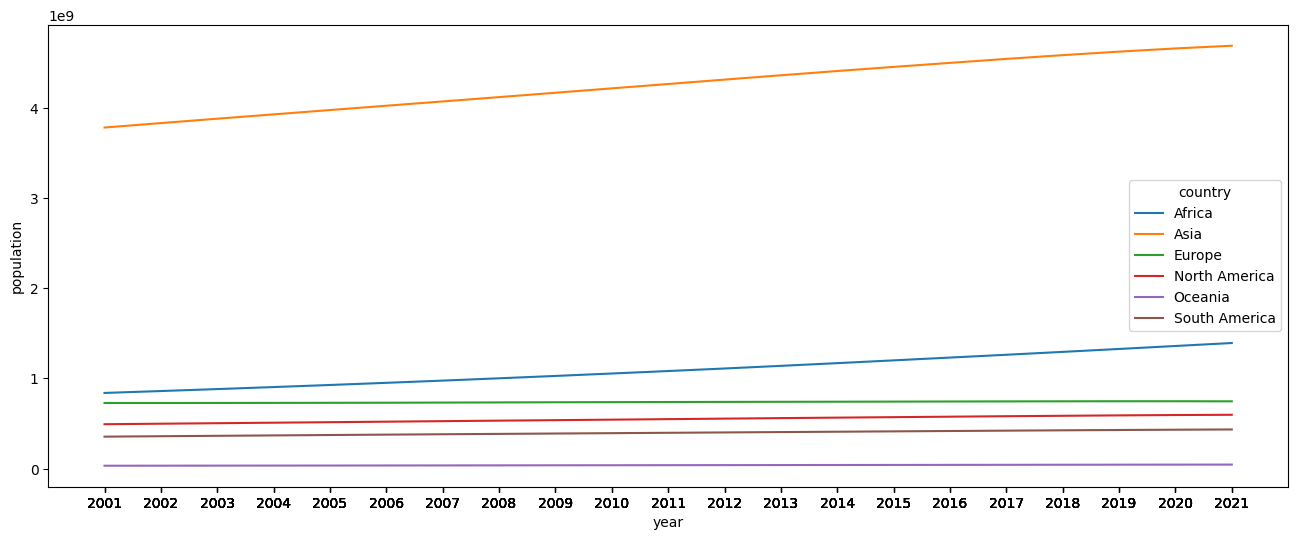

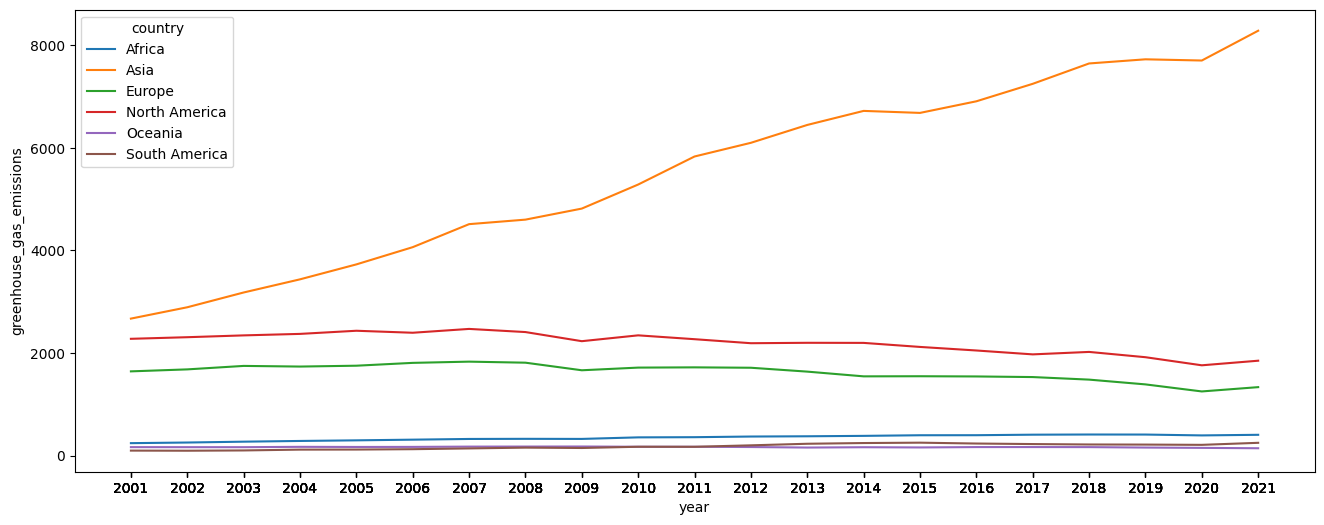

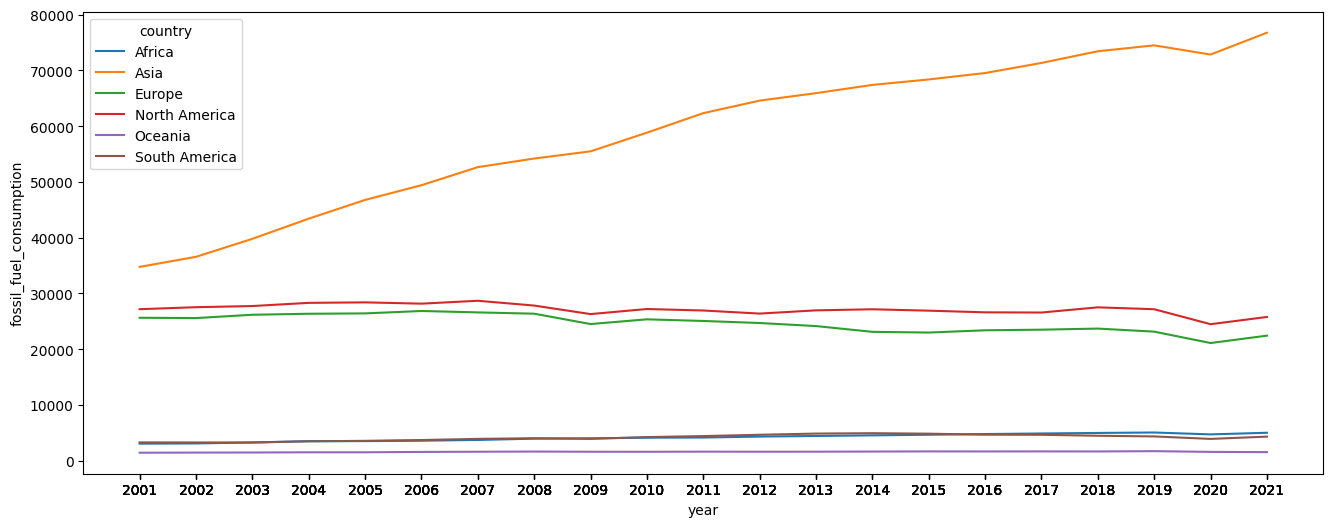

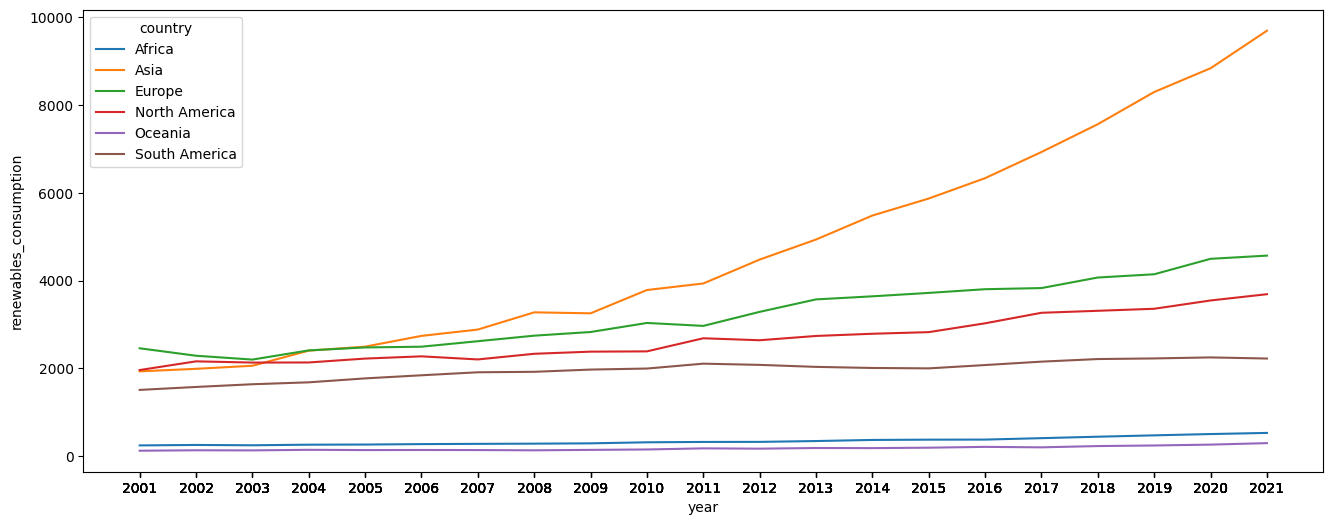

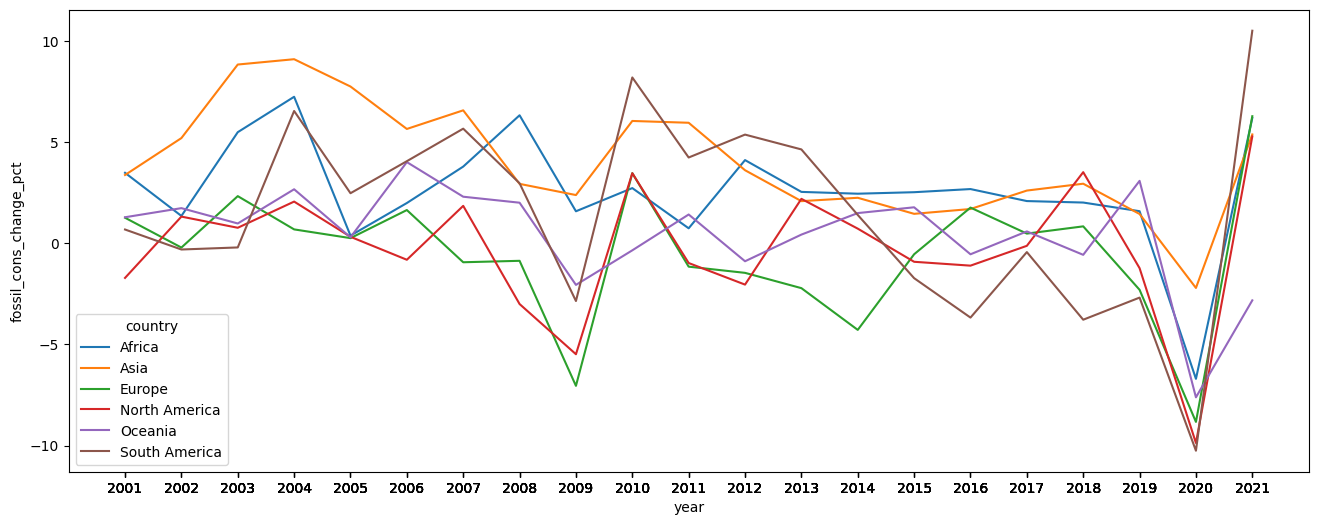

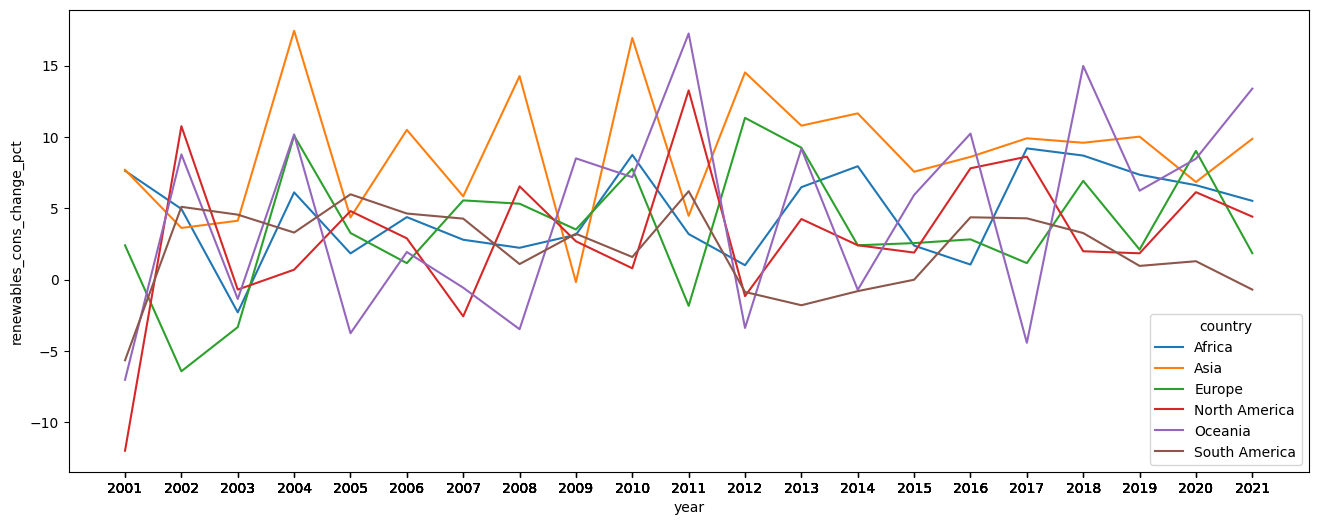

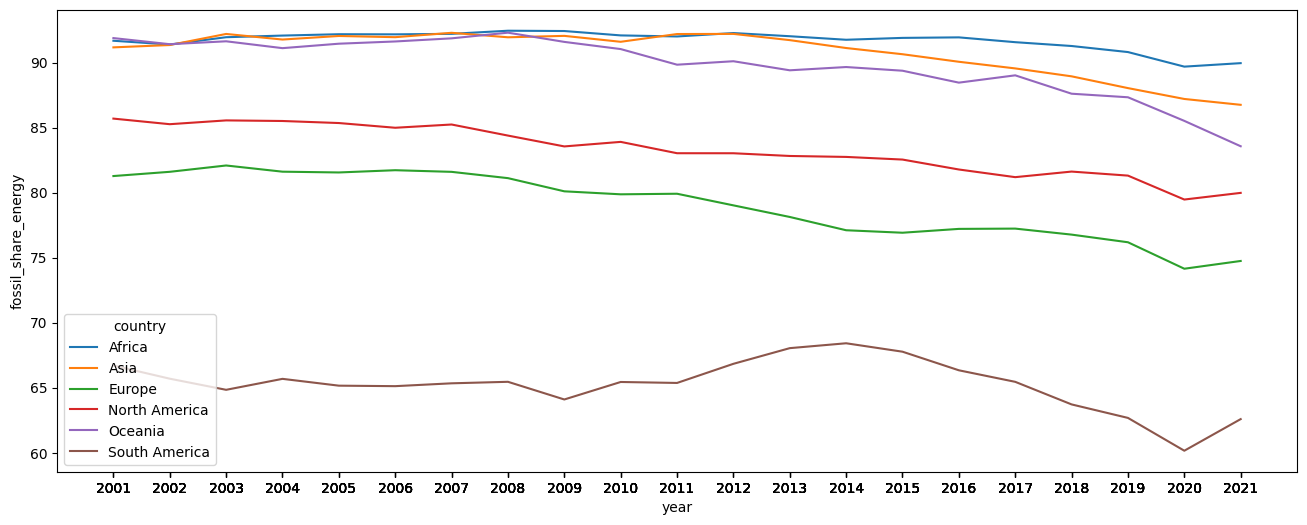

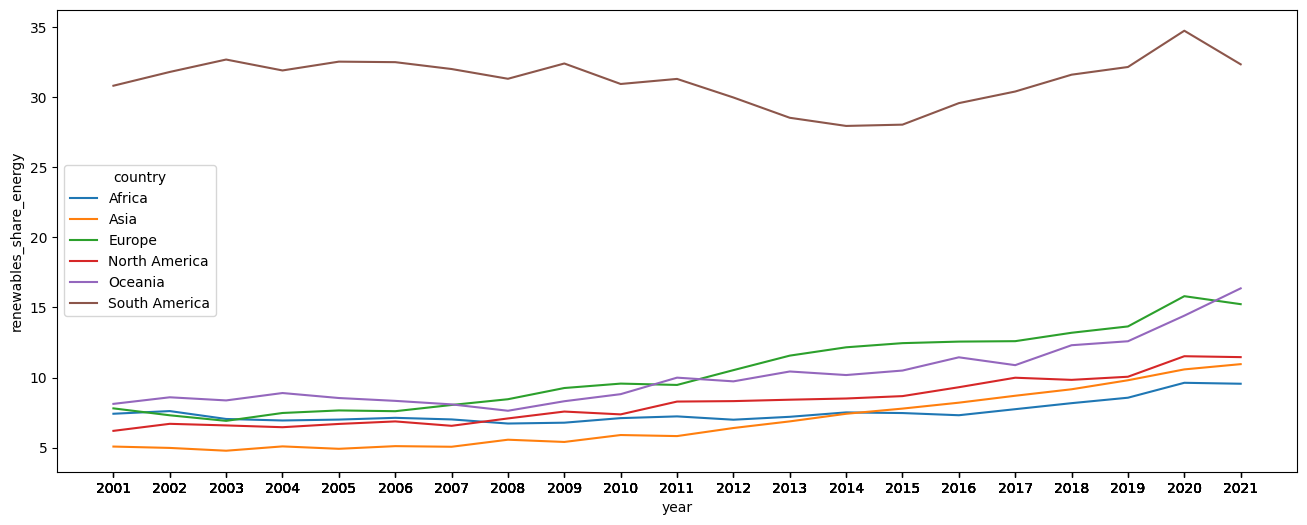

In [76]:
for metric in continent_metrics:
    figure = plt.figure(figsize=(16,6))
    sb.lineplot(data=continent_general_data, x = 'year', y = metric, hue = 'country')
    plt.xticks(continent_general_data["year"].astype(int))

Notice the following:
- **population**: Asia has a significant increase compared to other countries, Africa has a slight increase as well

- **greenhouse_gas_emissions**: Asia is the largest contributor

- **fossil_fuel_consumption**: Asia is the largest contributor

- **renewables_consumption**: Asia is the largest contributor & it looks more exponential than fossil fuel consumption

- **fossil_cons_change_pct**: Significant spikes upwards across all continents after 2020 - likely due to COVID-19 pandemic reopening

- **renewables_cons_change_pct**: Values for all continents remains in the positive change - means increase in renewable consumption

- **fossil_share_energy**: South America remains low (60-70%) compared to other continents (75%++). Africa and Asia has the highest percentages.

- **renewables_share_energy**: South America remains high (30%) compared to other continents (<15%). From 2012 onwards, a gradual rise from all countries


With this information, we can conclude that:

**_While there are increase in fossil fuel consumption is attributed to population increase AND increase in fossil fuel energy usage is met with an increase in renewable energy usage, we still see that fossil fuel reliance is high in most continents with percentages higher than 70% other than South America._**

### Comparison across __countries__ with identified parameters

We use fossil fuels and renewable energy to compare non-renewable vs renewable energy, similar to continent comparison.

For countries, we decide to use choropleths for data visualisation to easily, at a glance, see countries at the ends of each spectrum

**For this notebook, we get imports and set everything up to be working offline for plotly.**

In [77]:
import plotly.graph_objs as go 
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

# This allows figures to show up on the notebook
init_notebook_mode(connected=True)

In [78]:
# initialise countries dataframe for the 187 countries identified
country_data = df2[df2['iso_code'].isin(iso_countries)].copy()

# check which year has lesser null values for comparison on choropleths
for year in list(country_data['year'].unique()):
    print(year, country_data[country_data['year'] == year].isnull().sum().sum())

2001 5276
2002 5266
2003 5304
2004 5298
2005 5327
2006 5314
2007 5295
2008 5292
2009 5282
2010 5270
2011 5263
2012 5298
2013 5289
2014 5273
2015 5276
2016 5271
2017 5774
2018 5772
2019 6091
2020 6246
2021 6361


In [79]:
# 2021: 'population', 'greenhouse_gas_emissions', 'fossil_elec_per_capita', 'renewables_elec_per_capita'
country_data[country_data['year'] == 2021].isnull().sum().sort_values().head(20)

country                             0
low_carbon_electricity              0
low_carbon_share_elec               0
other_renewables_elec_per_capita    0
wind_share_elec                     0
renewables_elec_per_capita          0
renewables_electricity              0
renewables_share_elec               0
solar_elec_per_capita               0
other_renewables_share_elec         0
low_carbon_elec_per_capita          0
year                                0
solar_share_elec                    0
iso_code                            0
wind_elec_per_capita                0
population                          0
hydro_share_elec                    1
hydro_elec_per_capita               1
greenhouse_gas_emissions            1
net_elec_imports_share_demand       1
dtype: int64

In [80]:
# we pick those with very little NaN values
country_metrics = ['population', 'greenhouse_gas_emissions', 'fossil_elec_per_capita', 'renewables_elec_per_capita']

country_general_data = country_data[['year', 'country', 'iso_code'] + country_metrics].reset_index().copy()
country_general_data.drop(columns='index', inplace=True)
country_general_data.head()

,year,country,iso_code,population,greenhouse_gas_emissions,fossil_elec_per_capita,renewables_elec_per_capita
0,2001,Afghanistan,AFG,19688634.0,0.07,4.571,25.395
1,2002,Afghanistan,AFG,21000258.0,0.10,6.190,26.666
2,2003,Afghanistan,AFG,22645136.0,0.24,13.689,27.821
3,2004,Afghanistan,AFG,23553554.0,0.24,14.011,23.776
4,2005,Afghanistan,AFG,24411196.0,0.25,13.928,24.169


#### Choropleth for country data

In [81]:
choropleth_data = country_general_data[country_general_data['year'] == 2021].dropna().copy()

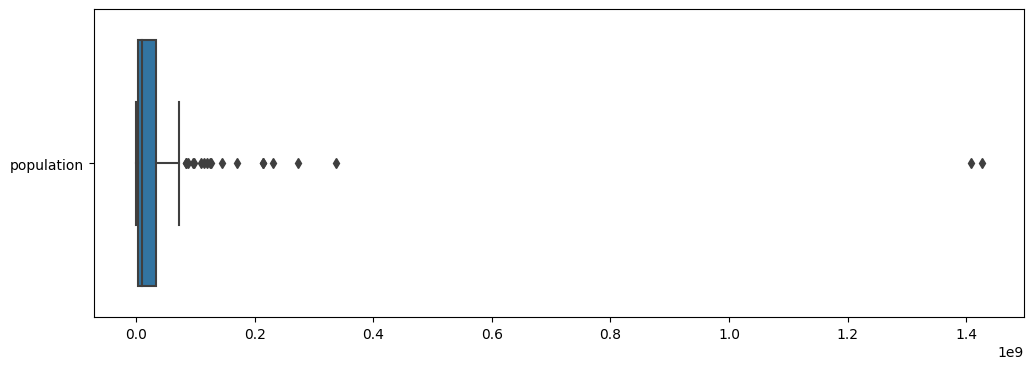

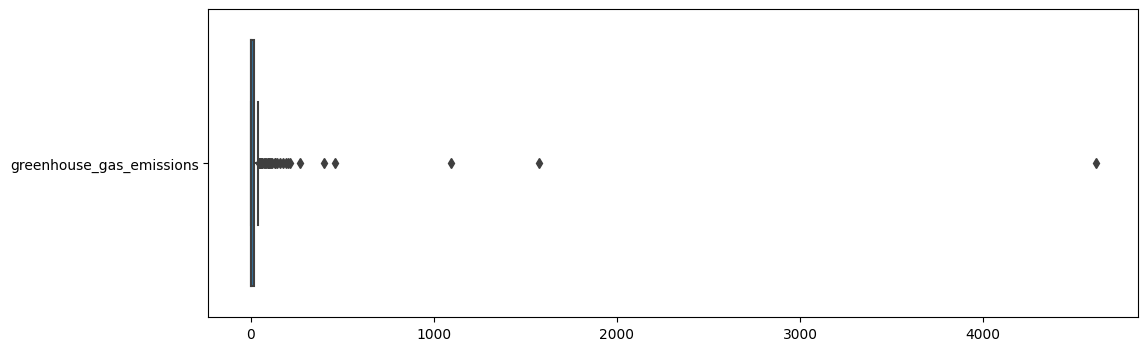

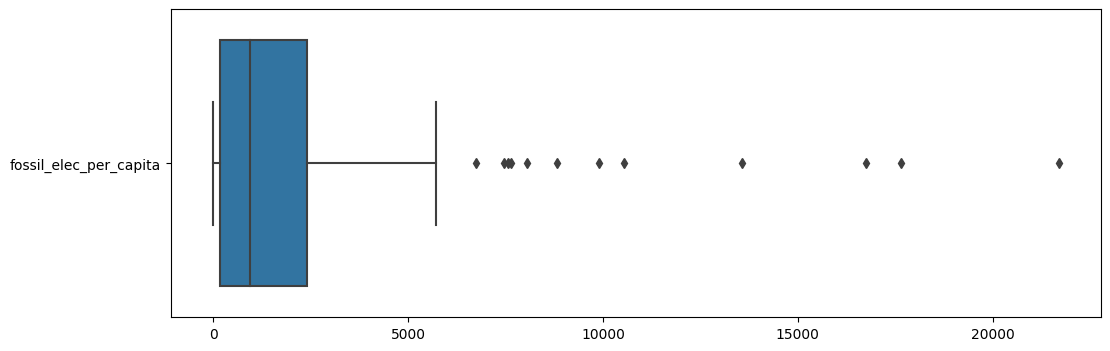

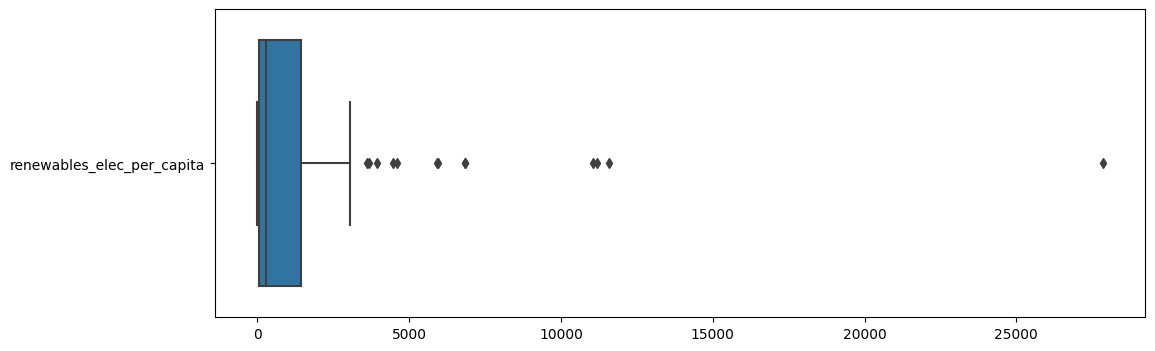

In [82]:
for column in list(choropleth_data.columns)[3:]:
    choro_data = pd.DataFrame(choropleth_data[column])
    f = plt.figure(figsize=(12,4))
    sb.boxplot(data=choro_data, orient = "h")

From the boxplots, we observe that the data is very skewed right due to outliers. We can rectify this by using truncated means to determine the colorscale 

In [83]:
# Create a dictionary to store the upper limits for each column
upper_limits = {}

# Loop over each column and calculate the truncated mean and standard deviation
for column in country_metrics:
    threshold = np.percentile(choropleth_data[column], 90)
    truncated_data = choropleth_data[choropleth_data[column] <= threshold][column]
    truncated_mean = np.mean(truncated_data)
    truncated_std = np.std(truncated_data)

    # Set the upper limit for the color scale to be 3 standard deviations above the truncated mean
    upper_limits[column] = truncated_mean + 3 * truncated_std

upper_limits

{'population': 65173972.077380344,
 'greenhouse_gas_emissions': 67.5081828242574,
 'fossil_elec_per_capita': 4857.936925473582,
 'renewables_elec_per_capita': 2681.535875482655}

In [154]:
data = dict(type = 'choropleth',
            locations = choropleth_data['iso_code'],
            z = np.log10(choropleth_data['greenhouse_gas_emissions']),
            text = choropleth_data['country'],
            colorbar = {'title' : 'Greenhouse Gas Emissions'},
            colorscale = 'Reds')

c:\Users\bklec\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:402: RuntimeWarning:

divide by zero encountered in log10



In [155]:
layout = dict(title = '2021 Greenhouse Gas Emissions', geo = dict(showframe = True, projection = {'type':'natural earth'}), margin = dict(l=0, r=0, t=0, b=0))

In [156]:
choromap = go.Figure(data = [data],layout = layout)
iplot(choromap)

#### Choropleth for fossil fuel share of electricity generation (2021)

In [87]:
data1 = dict(type = 'choropleth',
            locations = choropleth_data['iso_code'],
            z = choropleth_data['fossil_elec_per_capita'],
            text = choropleth_data['country'],
            colorbar = {'title' : 'Fossil Fuel Electricity Per Capita'},
            colorscale = 'Oranges',
            zmin = 0,
            zmax = upper_limits['fossil_elec_per_capita'])

In [88]:
layout1 = dict(title = '2021 Fossil Fuel Electricity Per Capita', geo = dict(showframe = True, projection = {'type':'natural earth'}), margin = dict(l=0, r=0, t=0, b=0))

In [89]:
choromap = go.Figure(data = [data1],layout = layout1)
iplot(choromap)

#### Choropleth for renewables share of electricity generation (2021)

In [90]:
data2 = dict(type = 'choropleth',
            locations = choropleth_data['iso_code'],
            z = choropleth_data['renewables_elec_per_capita'],
            text = choropleth_data['country'],
            colorbar = {'title' : 'Renewables as share of electricity generation (%)'},
            colorscale = 'Blues_r',
            zmin = 0,
            zmax = upper_limits['renewables_elec_per_capita'])

In [91]:
layout2 = dict(title = '2021 Renewables as share of electricity generation', geo = dict(showframe = True, projection = {'type':'natural earth'}), margin = dict(l=0, r=0, t=0, b=0))

In [92]:
choromap = go.Figure(data = [data2],layout = layout2)
iplot(choromap)

### Classification of Developed/Developing Countries:

As the nature of the classification is binary and the data is not labelled as 'developed' or 'developing', we will use an unsupervised clustering algorithm to define which is developed or developing - K-Means Clustering with 2 clusters.

__In general, countries in clusters with high values are 'developed' while clusters with low values are 'developing'__

We evaluate the credibility of our model with:
1. Silhouette score: The silhouette score measures how well each data point fits into its assigned cluster, based on how similar it is to the other points in its own cluster compared to the points in the other clusters. A higher silhouette score indicates that the clusters are well separated and that the data points are well matched to their assigned clusters.

2. Within-cluster sum of squares (WCSS): WCSS measures the sum of the squared distances between each data point and the centroid of its assigned cluster. A lower WCSS indicates that the clusters are more tightly packed and that the data points are more similar to each other within each cluster.

In [93]:
country_data['country'].value_counts().sort_values().head(7)

South Sudan             10
Montenegro              17
Micronesia (country)    19
Timor                   19
Tuvalu                  19
Albania                 20
Bolivia                 21
Name: country, dtype: int64

As the original dataset has a lot of missing GDP values as well as missing countries for certain years, we will use external dataset for our first round of clustering

Energy per capita - 2018 values (given dataset)

GDP per capita - 2018 values (external data set - World Bank)

HDI - 2021 values (external data set - UNHDR)

In [94]:
original_df = country_data[['country', 'iso_code','year', 'energy_per_capita']][country_data['year'] == 2018]
original_df.head()

,country,iso_code,year,energy_per_capita
17,Afghanistan,AFG,2018,1144.532
38,Albania,ALB,2018,14483.855
58,Algeria,DZA,2018,16012.625
79,Angola,AGO,2018,3165.137
100,Antigua and Barbuda,ATG,2018,33115.695


In [95]:
hdi_data = pd.read_excel('HDR21-22_Statistical_Annex_HDI_Table.xlsx')
hdi_data = hdi_data.iloc[8:201, 1:4].reset_index().drop(columns='index')

In [112]:
hdi_data = hdi_data.rename(columns={'Table 1. Human Development Index and its components' : 'country', 
                                    'Unnamed: 2' : 'hdi', 
                                    'Unnamed: 3' : 'life_expectancy'})
hdi_data = hdi_data.sort_values(by = 'hdi').dropna()
hdi_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 192 to 0
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   country          190 non-null    object
 1   hdi              190 non-null    object
 2   life_expectancy  190 non-null    object
dtypes: object(3)
memory usage: 5.9+ KB


In [97]:
gdppc_data = pd.read_excel('energy_data.xlsx', sheet_name = 'gdp per capita')
gdppc_data = gdppc_data.iloc[:, [1] + list(range(42, len(gdppc_data.columns)))]
gdppc_data = gdppc_data.rename(columns={'Country Code' : 'iso_code'})

In [98]:
gdppc_data_melted = gdppc_data.melt(id_vars='iso_code', var_name='year', value_name='gdp_per_capita')
gdppc_data_melted['year'] = gdppc_data_melted['year'].astype('int64')

In [99]:
merged_df = pd.merge(original_df, gdppc_data_melted, on=['iso_code', 'year'], how='left')
merged_df

,country,iso_code,year,energy_per_capita,gdp_per_capita
0,Afghanistan,AFG,2018,1144.532,502.056771
1,Albania,ALB,2018,14483.855,5287.663694
2,Algeria,DZA,2018,16012.625,4171.795011
3,Angola,AGO,2018,3165.137,2487.500996
4,Antigua and Barbuda,ATG,2018,33115.695,17527.169629
...,...,...,...,...,...
182,Venezuela,VEN,2018,23453.379,NaN
183,Vietnam,VNM,2018,11443.453,3267.225009
184,Yemen,YEM,2018,1168.473,701.714878
185,Zambia,ZMB,2018,3472.000,1475.204538


In [100]:
final_df = pd.merge(merged_df, hdi_data, on='country', how='left')
final_df

,country,iso_code,year,energy_per_capita,gdp_per_capita,hdi,life_expectancy
0,Afghanistan,AFG,2018,1144.532,502.056771,0.478,61.9824
1,Albania,ALB,2018,14483.855,5287.663694,0.796,76.4626
2,Algeria,DZA,2018,16012.625,4171.795011,0.745,76.3767
3,Angola,AGO,2018,3165.137,2487.500996,0.586,61.6434
4,Antigua and Barbuda,ATG,2018,33115.695,17527.169629,0.788,78.4968
...,...,...,...,...,...,...,...
182,Venezuela,VEN,2018,23453.379,NaN,NaN,NaN
183,Vietnam,VNM,2018,11443.453,3267.225009,0.703,73.6181
184,Yemen,YEM,2018,1168.473,701.714878,0.455,63.7534
185,Zambia,ZMB,2018,3472.000,1475.204538,0.565,61.2234


In [101]:
hdi_mask = final_df[final_df['year'] == 2018]['hdi'].isnull()
hdi_mask.groupby(final_df['country']).sum().sort_values(ascending=False).head(10)

country
Syria                   1
Micronesia (country)    1
Nauru                   1
Venezuela               1
North Korea             1
South Sudan             1
Somalia                 1
Nicaragua               0
Niger                   0
Nigeria                 0
Name: hdi, dtype: int64

In [102]:
gdp_mask = final_df[final_df['year'] == 2018]['gdp_per_capita'].isnull()
gdp_mask.groupby(final_df['country']).sum().sort_values(ascending=False).head(10)

country
North Korea         1
Venezuela           1
Eritrea             1
South Sudan         1
Afghanistan         0
Papua New Guinea    0
Niger               0
Nigeria             0
North Macedonia     0
Norway              0
Name: gdp_per_capita, dtype: int64

We will drop the countries with missing data for now - **Syria, Eritrea, Venezuela, South Sudan, North Korea, Nauru, Somalia and Micronesia (country)**.

In [103]:
dropped_countries = ["Syria", "Eritrea", "Venezuela", "South Sudan", "North Korea", "Nauru", "Somalia", "Micronesia (country)"]
final_df = final_df.drop(final_df[final_df['country'].isin(dropped_countries)].index)
final_df.isnull().sum()

country              0
iso_code             0
year                 0
energy_per_capita    0
gdp_per_capita       0
hdi                  0
life_expectancy      0
dtype: int64

We now plot scatter plots for the selected indices

<Axes: xlabel='hdi', ylabel='gdp_per_capita'>

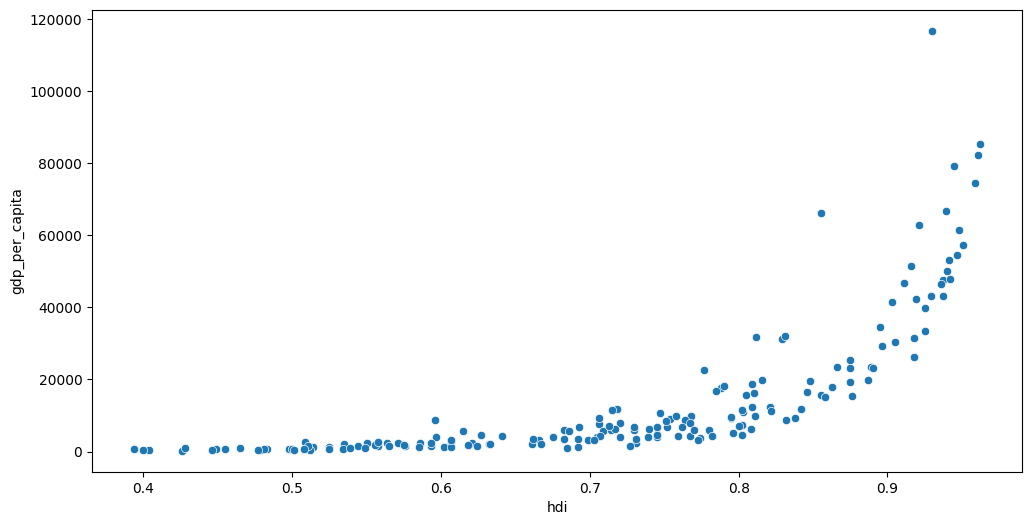

In [104]:
figure = plt.figure(figsize=(12,6))
sb.scatterplot(data=final_df, x = 'hdi', y = 'gdp_per_capita')

<Axes: xlabel='energy_per_capita', ylabel='gdp_per_capita'>

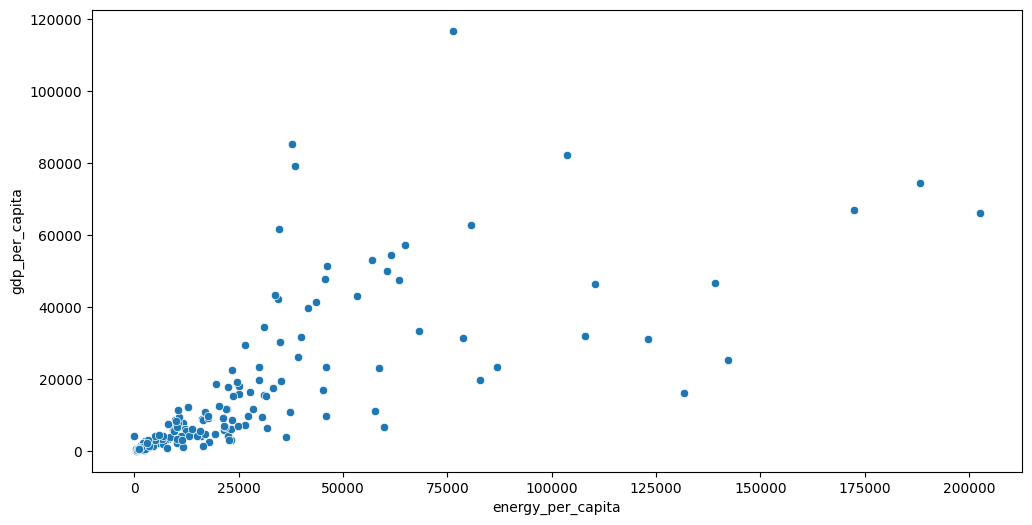

In [105]:
figure = plt.figure(figsize=(12,6))
sb.scatterplot(data=final_df, x = 'energy_per_capita', y = 'gdp_per_capita')

<Axes: xlabel='hdi', ylabel='life_expectancy'>

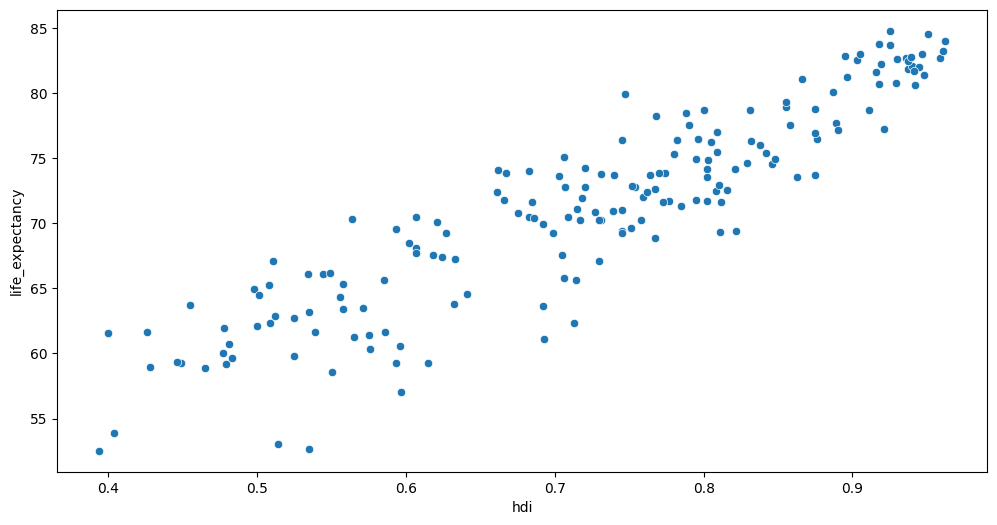

In [106]:
figure = plt.figure(figsize=(12,6))
sb.scatterplot(data=final_df, x = 'hdi', y = 'life_expectancy')

In [107]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [108]:
# Standardize the data
scaler = StandardScaler()
scaled_final_df = scaler.fit_transform(final_df[['energy_per_capita', 'gdp_per_capita']])

In [109]:
# Initialize KMeans with hyperparameters
Kmean = KMeans(n_clusters=2, n_init=10)
Kmean.fit(scaled_final_df)

# Get the cluster labels and number of clusters
Kmean.cluster_centers_

# Predict cluster labels
labels = Kmean.predict(scaled_final_df)


<Axes: xlabel='Cluster', ylabel='count'>

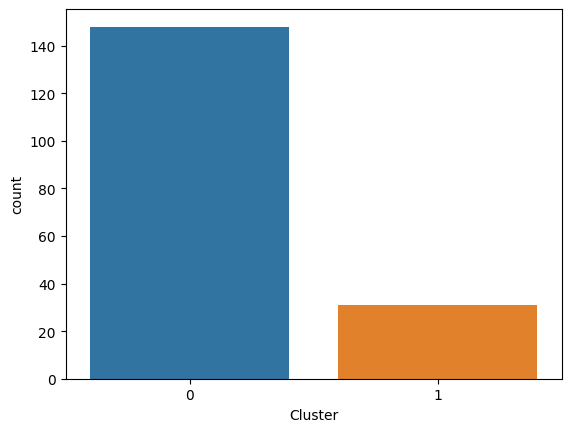

In [110]:
# Append Labels to the Data
scaled_final_df_labelled = pd.DataFrame(scaled_final_df.copy(), columns=['energy_per_capita', 'gdp_per_capita'])
scaled_final_df_labelled['Cluster'] = pd.Categorical(labels)

# Summary of the Cluster Labels
sb.countplot(x=scaled_final_df_labelled["Cluster"])

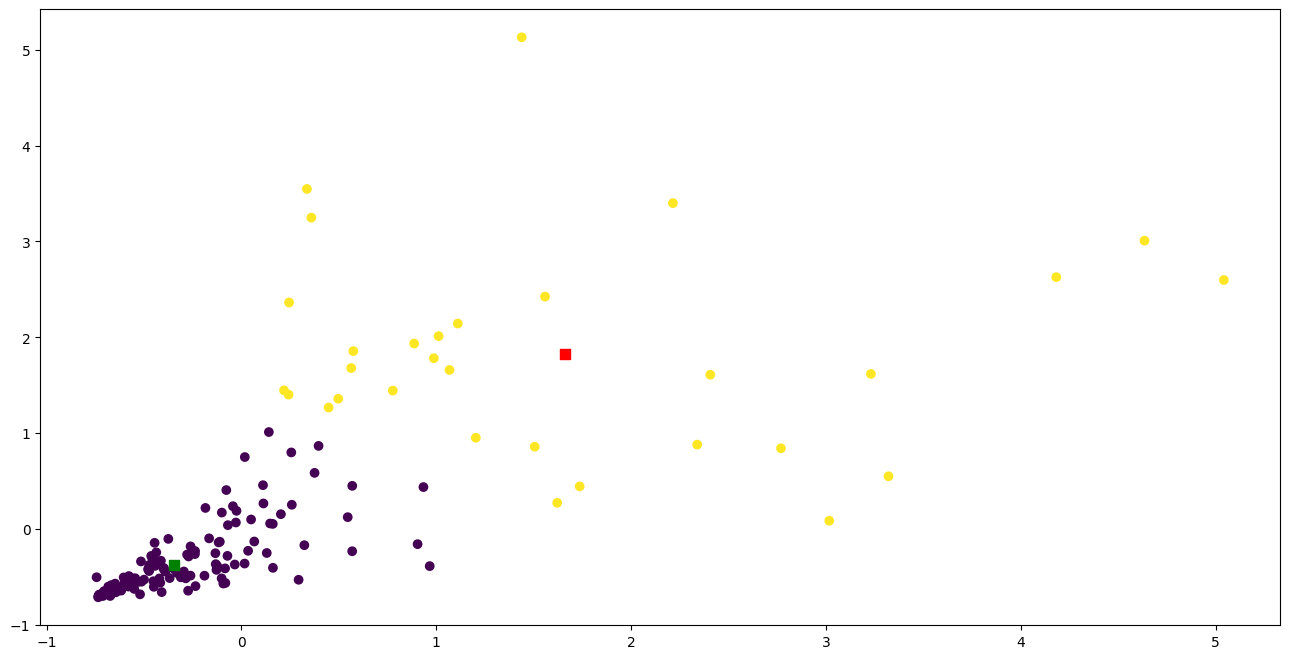

In [111]:
f, axes = plt.subplots(1, 1, figsize=(16,8))
plt.scatter(x = 'energy_per_capita', y = 'gdp_per_capita', c = 'Cluster', cmap = 'viridis', data = scaled_final_df_labelled)
plt.scatter(-0.34831182, -0.38138367, s=50, c='g', marker="s")
plt.scatter(1.66290804, 1.82079946, s=50, c='r', marker="s")

### Clustering countries based on their energy usage (within 'developed' cluster and 'developing' cluster)

In [150]:
country_2021 = country_data[country_data['year'] == 2021]
country_2021

,country,year,iso_code,population,gdp,biofuel_cons_change_pct,biofuel_cons_change_twh,biofuel_cons_per_capita,biofuel_elec_per_capita,biofuel_share_elec,...,solar_cons_change_pct,solar_elec_per_capita,solar_energy_per_capita,solar_share_elec,solar_share_energy,wind_cons_change_pct,wind_elec_per_capita,wind_energy_per_capita,wind_share_elec,wind_share_energy
20,Afghanistan,2021,AFG,40099460.0,NaN,NaN,NaN,NaN,0.000,0.000,...,NaN,1.995,NaN,9.639,NaN,NaN,0.000,NaN,0.000,NaN
61,Algeria,2021,DZA,44177964.0,NaN,NaN,NaN,NaN,0.000,0.000,...,-3.066,18.335,39.329,1.045,0.254,36.364,0.226,0.622,0.013,0.004
82,Angola,2021,AGO,34503776.0,NaN,NaN,NaN,NaN,8.115,1.704,...,NaN,0.580,NaN,0.122,NaN,NaN,0.000,NaN,0.000,NaN
103,Antigua and Barbuda,2021,ATG,93229.0,NaN,NaN,NaN,NaN,0.000,0.000,...,NaN,214.526,NaN,5.714,NaN,NaN,0.000,NaN,0.000,NaN
124,Argentina,2021,ARG,45276788.0,NaN,8.019,0.774,230.13,44.394,1.370,...,63.317,47.927,126.888,1.479,0.603,37.478,282.926,747.699,8.733,3.551
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3820,Venezuela,2021,VEN,28199862.0,NaN,NaN,NaN,NaN,0.000,0.000,...,-0.273,0.355,0.286,0.011,0.001,-0.273,3.192,7.729,0.095,0.039
3841,Vietnam,2021,VNM,97468024.0,NaN,NaN,NaN,NaN,1.642,0.065,...,137.297,264.394,691.846,10.528,5.620,122.726,24.521,64.206,0.976,0.522
3862,Yemen,2021,YEM,32981644.0,NaN,NaN,NaN,NaN,0.000,0.000,...,NaN,18.192,NaN,17.045,NaN,NaN,0.000,NaN,0.000,NaN
3883,Zambia,2021,ZMB,19473132.0,NaN,NaN,NaN,NaN,5.649,0.621,...,NaN,7.703,NaN,0.847,NaN,NaN,0.000,NaN,0.000,NaN


In [142]:
import plotly.express as px

<Axes: xlabel='fossil_elec_per_capita', ylabel='renewables_elec_per_capita'>

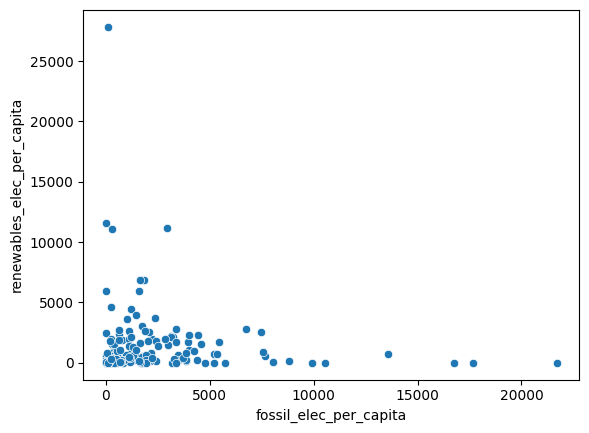

In [143]:
sb.scatterplot(data = country_2021, x = 'fossil_elec_per_capita', y = 'renewables_elec_per_capita')

In [144]:
fig = px.scatter(country_2021, x="fossil_elec_per_capita", y="renewables_elec_per_capita", hover_data=['country'])
fig.show()